In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
import sys
import pathlib

In [5]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import the local package 

In [6]:
sys.path.append('../../')

In [7]:
import numpy as np 
import pandas as pd
from cartopy import crs as ccrs

In [8]:
from ICU_Water_Watch import plot, utils, GPM, geo

### first step, we update the local GPM-IMERG dataset on disk, which is in by default `/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP`

In [9]:
# GPM.update(lag=1)

In [10]:
ndays = 90

In [11]:
dpath_realtime = pathlib.Path('/media/nicolasf/END19101/data/GPM_IMERG/daily/extended_SP/')

In [12]:
lfiles = GPM.get_files_list(dpath = dpath_realtime, ndays=ndays, lag=2)

In [13]:
len(lfiles)

90

In [14]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/data/GPM_IMERG/daily/extended_SP/GPM_IMERG_daily.v06.2022.06.26.nc')

In [15]:
dset = GPM.make_dataset(lfiles, ndays=ndays)

In [16]:
dset.dims

Frozen({'time': 90, 'lat': 300, 'lon': 460})

In [17]:
dset.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>

### get the last date and the number of days in the dataset, which are created automatically as global attributes in the dataset 

In [18]:
last_date, ndays_dset  = GPM.get_attrs(dset)

In [19]:
last_date

datetime.datetime(2022, 6, 26, 0, 0)

In [20]:
ndays_dset

90

### stations to extract 

In [31]:
stations_to_extract = pd.read_csv('./virtual_stations.csv', index_col=0)

In [32]:
stations_to_extract

,station_name,station_lat,station_lon
0,Nanumea,-5.661400,176.103600
1,Nanumaga,-6.285800,176.319900
2,Niutao,-6.106400,177.343800
3,Banaba,-0.857052,169.538569
4,Kuria Island,0.212635,173.428428
5,Aranuka Island,0.189632,173.634765
6,Tabiauea,0.922413,173.027021
7,Tarawa,1.443722,172.985565
8,Abaiang,1.850733,172.928745
9,Marakei Island,2.000318,173.276716


In [33]:
dpath_realtime

PosixPath('/media/nicolasf/END19101/data/GPM_IMERG/daily/extended_SP')

In [34]:
dpath_climatology = dpath_realtime.joinpath('CLIMATOLOGY')

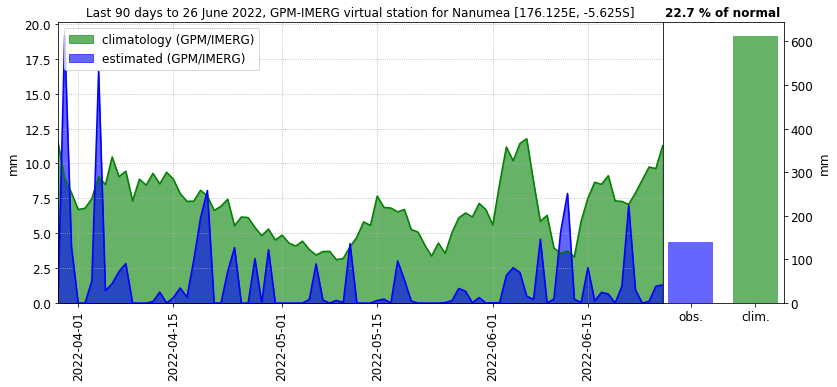

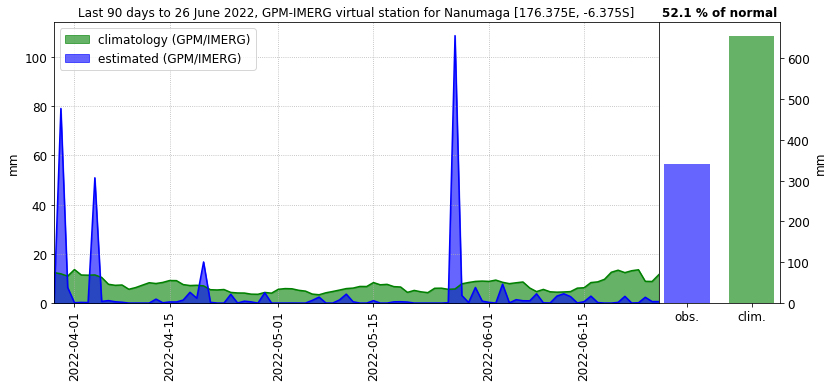

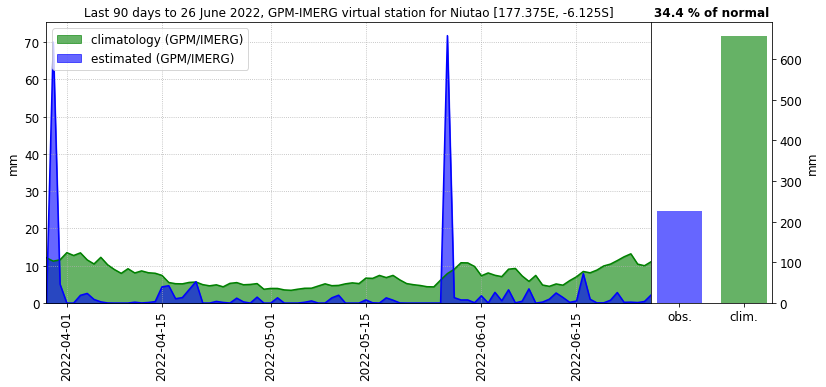

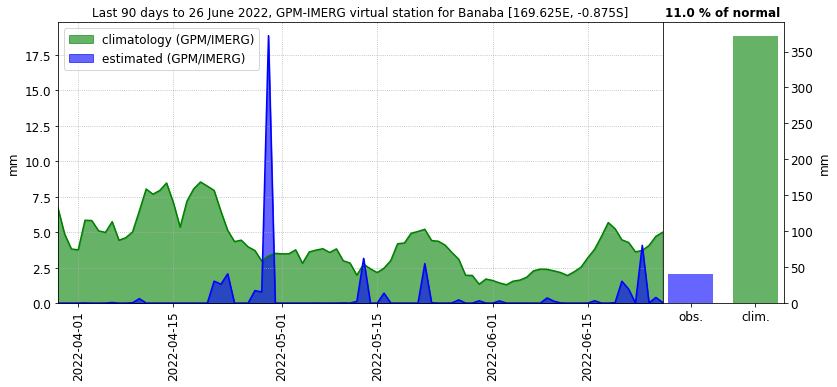

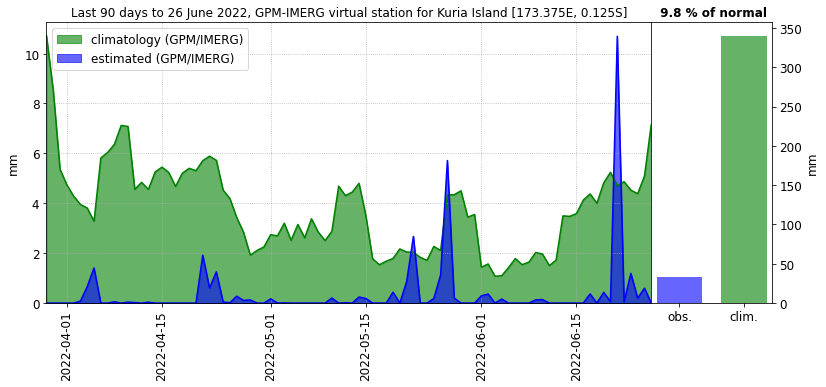

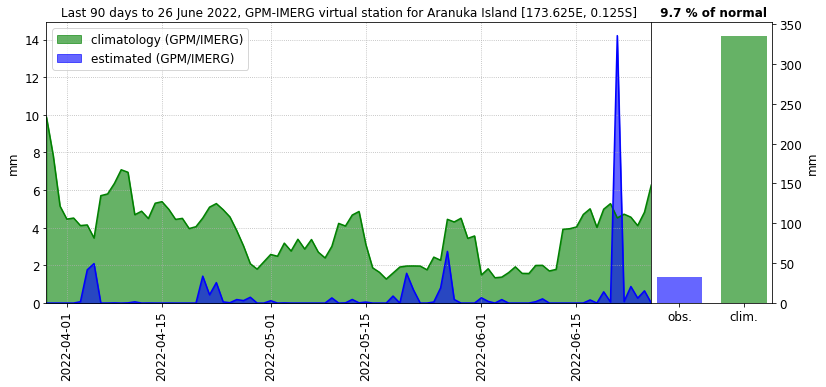

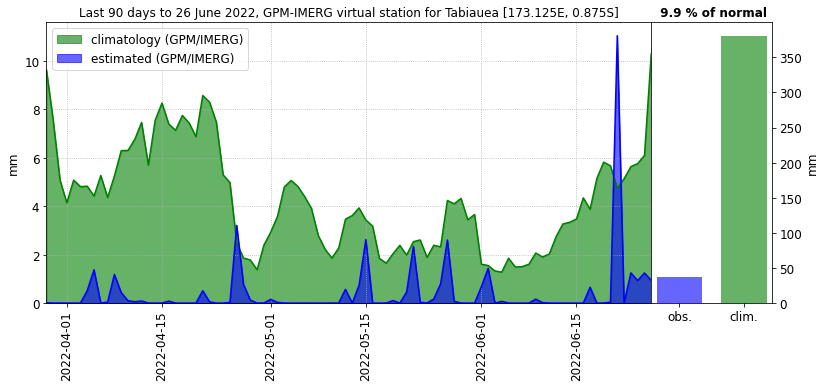

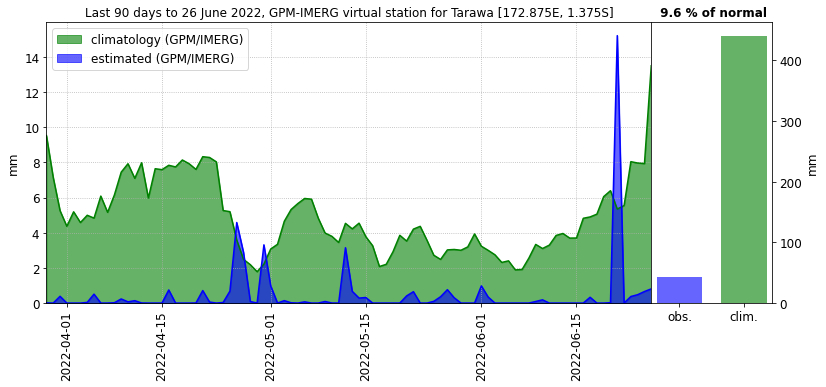

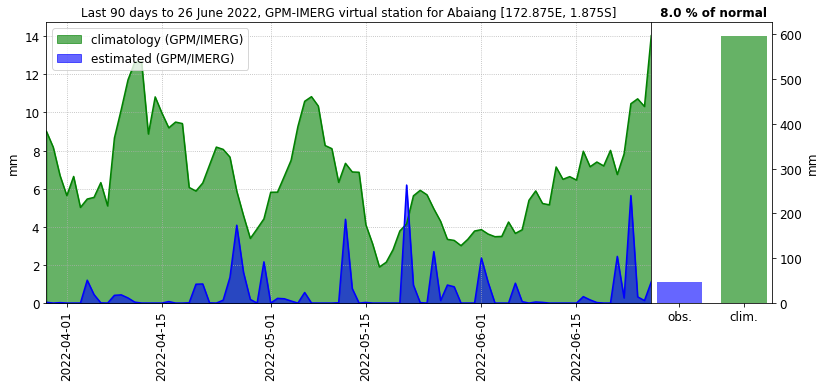

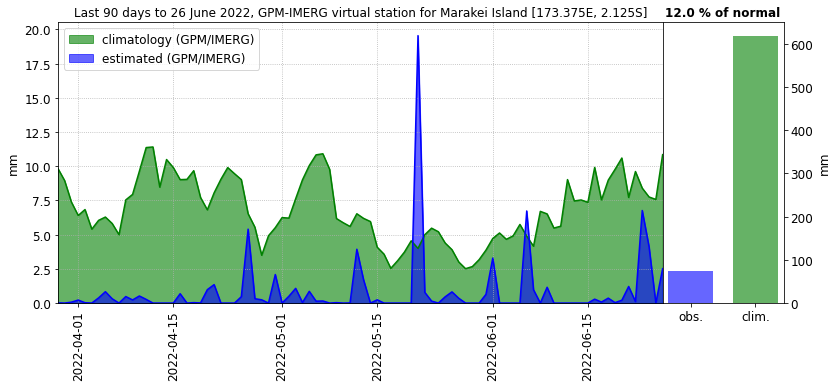

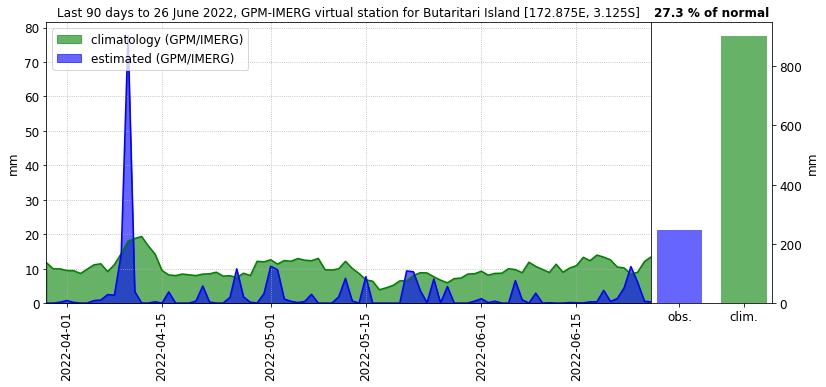

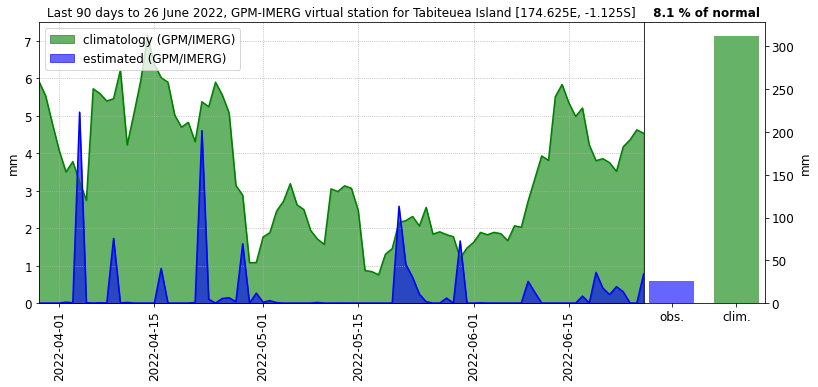

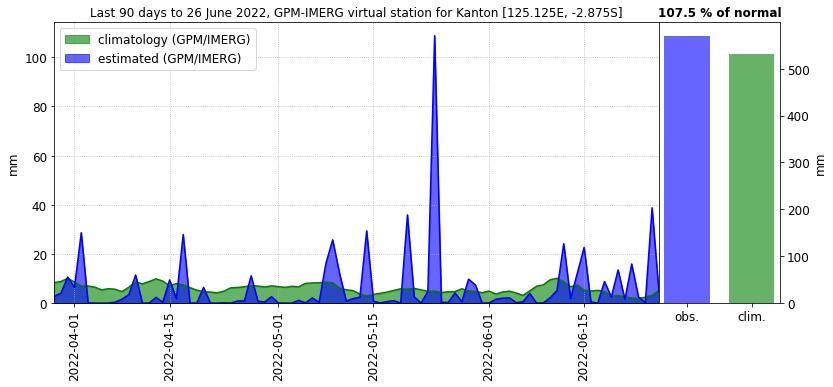

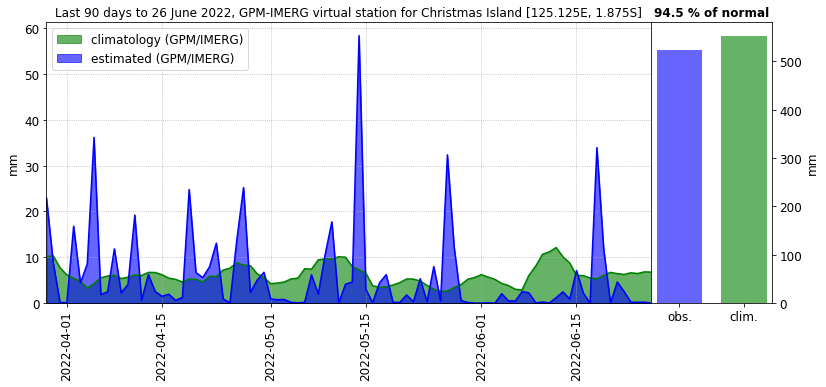

In [35]:
for i, row in stations_to_extract.iterrows(): 

    station_name = row.station_name 
    station_lat = row.station_lat 
    station_lon = row.station_lon 

    df, extracted_coords, dist = GPM.get_virtual_station(dset, lat=station_lat, lon=station_lon)

    clim = GPM.get_virtual_station_climatology(dpath=dpath_climatology, lat=station_lat, lon=station_lon)

    df = GPM.join_clim(df, clim)

    f = plot.plot_virtual_station(df, station_name=station_name, lon=extracted_coords[0], lat=extracted_coords[-1])

    f.savefig(f'/home/nicolasf/Desktop/{utils.sanitize_name(station_name)}_virtual_station_{ndays}.png', dpi=200, facecolor='w', bbox_inches='tight')

### calculate the rainfall accumulation over the past N days 

In [33]:
dset_accum = GPM.calculate_realtime_accumulation(dset)

In [34]:
dset_accum.dims

Frozen({'lat': 300, 'lon': 460, 'time': 1})

In [35]:
dset_accum.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 376.0 390.0 400.0 ... 3.554 12.85

### get the rain days stats: number of rain days (threshold = 1 mm/day), number of dry days, and number of days since last rain

In [36]:
dset_ndays = GPM.get_rain_days_stats(dset)

In [37]:
dset_ndays.dims

Frozen({'lat': 300, 'lon': 460, 'time': 1})

In [38]:
dset_ndays.data_vars

Data variables:
    wet_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    dry_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    days_since_rain  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>

### get the climatology, for the calculation of the anomalies 

In [39]:
clim = GPM.get_climatology(dpath=dpath_realtime, ndays=ndays, date=last_date)

### calculates the anomalies and the percentages of scores, and insert the resulting variables (`anoms` and `pctscore`) in the dataset 

In [40]:
dset_accum = GPM.calc_anoms_and_pctscores(dset_accum, clim)

In [41]:
dset_accum.dims

Frozen({'time': 1, 'lat': 300, 'lon': 460})

In [42]:
dset_accum.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 376.0 390.0 400.0 ... 3.554 12.85
    pctscore          (time, lat, lon) float64 95.0 95.0 95.0 ... 8.0 10.0 36.0
    anoms             (time, lat, lon) float64 92.73 102.0 ... -21.5 -12.57

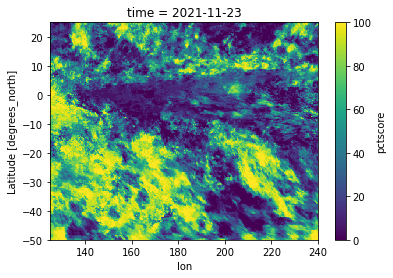

In [43]:
dset_accum.pctscore.plot()

### saves the percentage of score, for checks 

In [44]:
dset_accum[['pctscore']].to_netcdf('./pctscore.nc')

### get the EEZs for each country, and a dissolved version for the mask 

In [45]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### insert the mask in each dataset 

In [46]:
dset_accum = geo.make_mask_from_gpd(dset_accum, merged_EEZs, subset=True, mask_name='EEZ')

In [47]:
dset_ndays = geo.make_mask_from_gpd(dset_ndays, merged_EEZs, subset=True, mask_name='EEZ')

### plots the precipitation accumulation 

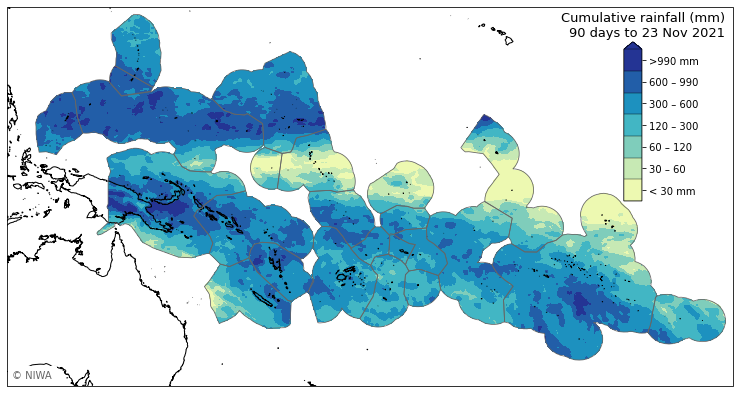

In [48]:
plot.map_precip_accum(dset_accum, mask='EEZ', close=False, geoms=EEZs, fpath='/home/nicolasf/Desktop/')

### Plots the precipitation anomalies 

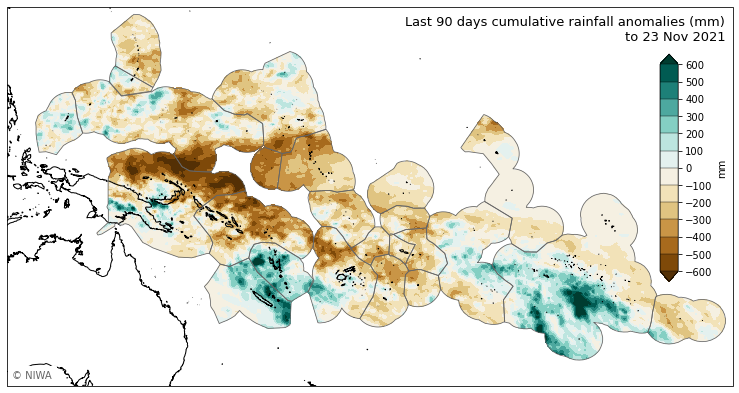

In [49]:
plot.map_precip_anoms(dset_accum, mask='EEZ', close=False, geoms=EEZs, fpath='/home/nicolasf/Desktop/')

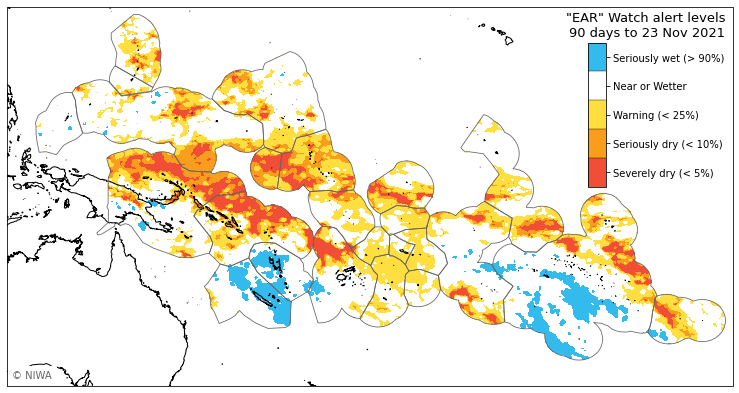

In [50]:
plot.map_EAR_Watch_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='/home/nicolasf/Desktop/')

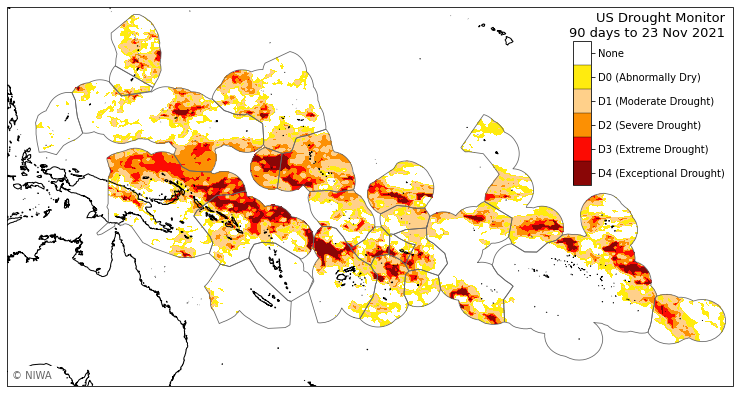

In [51]:
plot.map_USDM_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='/home/nicolasf/Desktop/')

### creates on dataset per country, including the EEZ mask, which then could be exported if needed 

In [52]:
for i, country_name in enumerate(EEZs.COUNTRYNAM): 
    c = EEZs.query(f"COUNTRYNAM == '{country_name}'")
    sub = geo.make_mask_from_gpd(dset_accum, c, mask_name='mask_EEZ')

In [53]:
country_name

'French Polynesia'

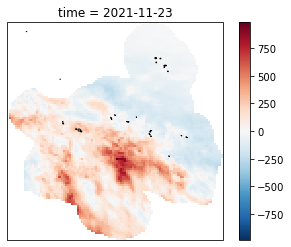

In [54]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
(sub['anoms'] * sub['mask_EEZ']).squeeze().plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [55]:
dset_accum

<xarray.Dataset>
Dimensions:           (time: 1, lat: 220, lon: 439)
Coordinates:
  * time              (time) datetime64[ns] 2021-11-23
  * lat               (lat) float64 -30.88 -30.62 -30.38 ... 23.38 23.62 23.88
  * lon               (lon) float64 129.4 129.6 129.9 ... 238.4 238.6 238.9
Data variables:
    precipitationCal  (time, lat, lon) float64 113.0 122.5 131.3 ... 24.3 47.08
    pctscore          (time, lat, lon) float64 55.0 65.0 65.0 ... 32.0 69.0 75.0
    anoms             (time, lat, lon) float64 -0.441 10.63 ... -4.535 19.26
    EEZ               (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    BeginDate:       2021-08-26
    BeginTime:       00:00:00.000Z
    EndDate:         2021-08-26
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-08-26T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210826-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-08-27T14:43:13.869Z
    ndays:           90
    last_day:        2021-11-23